In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import pickle
import sys

from konlpy.tag import Kkma, Okt
import gc

import re
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

In [2]:
from ksenticnet_kaist import *

ksenticnet = get_ksenticnet()

keys = list(ksenticnet.keys())
senticvals = [[float(i) for i in val[:4]] for val in  ksenticnet.values()]
sentiments = []
polarity = []
semantics = []
for key, val in ksenticnet.items():
    for i in val[4:]:
        if i in ['positive', 'negative']:
            polar_ind = val.index(i)
            sentiments.append(val[4 : polar_ind])
            polarity.append(val[polar_ind : polar_ind+2])
            semantics.append(val[polar_ind+2 :])
            break

ksenticnets = defaultdict(dict)
for key, val, senti, p, seman in zip(keys, 
                                     senticvals, 
                                     sentiments, 
                                     polarity, 
                                     semantics):
    ksenticnets[key]['sentic_value'] = val
    ksenticnets[key]['sentiment'] = senti
    ksenticnets[key]['polarity'] = p
    ksenticnets[key]['semantic'] = seman

f = lambda x : [i if i > 0 else 0 for i in x]
g = lambda x : [abs(i) if i < 0 else 0 for i in x]
scores = np.array(list(map(lambda x : f(x) + g(x), senticvals)))
scores /= scores.sum(axis=1).reshape(-1, 1)

class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores

In [3]:
MAX_VOCAB_SIZE = 50000

def sampleFromDirichlet(alpha):
    return np.random.dirichlet(alpha)

def sampleFromCategorical(theta):
    theta = theta / np.sum(theta)
    return np.random.multinomial(1, theta).argmax()

def word_indices(wordOccurenceVec):
    for idx in wordOccurenceVec.nonzero()[0]:
        for i in range(int(wordOccurenceVec[idx])):
            yield idx
            
class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores
    
class SentimentLDAGibbsSampler:
    
    def __init__(self, numTopics, alpha, beta, gamma, numSentiments=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.numTopics = numTopics
        self.numSentiments = numSentiments
        
    def processSingleReview(self, review, st, d=None, stopwords=None):
        letters_only = re.sub('[^ㄱ-하-ㅣ가-힣]', ' ', review).strip()
        if not stopwords:
            stops = list('의가이은을로들는좀잘걍과도를자에와한것') + ['으로', '하다']
        else:
            stops = stopwords
        words = st.morphs(letters_only, stem=True, norm=True)
        meaningful_words = [w for w in words if w not in stops]
        return ' '.join(meaningful_words)
    
    def processReviews(self, reviews, st, saveAs=None, saveOverride=False, 
                       do_preprocess=True, return_processed_review=False):
        import os
        import dill
        if not saveOverride and saveAs and os.path.isfile(saveAs):
            [wordOccurenceMatrix, self.vectorizer] = dill.load(open(saveAs, 'r'))
            return wordOccurenceMatrix
        if do_preprocess:
            processed_reviews = []
            for i, review in enumerate(reviews):
                if (i + 1) % 10000 == 0:
                    print(' Review {} of {}'.format(i + 1, len(reviews)))
                processed_reviews.append(self.processSingleReview(review, st, i))
        else:
            processed_reviews = reviews
        if return_processed_review:
            return processed_reviews
        self.vectorizer = CountVectorizer(analyzer='word',
                                          tokenizer=None,
                                          preprocessor=None,
                                          max_features=MAX_VOCAB_SIZE)
        train_data_features = self.vectorizer.fit_transform(processed_reviews)
        wordOccurenceMatrix = train_data_features
        if saveAs:
            dill.dump([wordOccurenceMatrix, self.vectorizer], open(saveAs, 'w'))
        return wordOccurenceMatrix
    
    def _initialize_(self, reviews, st, saveAs=None, saveOverride=False, do_preprocess=True):
        self.wordOccurenceMatrix = self.processReviews(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        
        # Pseudocounts
        self.n_dt = np.zeros((numDocs, self.numTopics))
        self.n_dts = np.zeros((numDocs, self.numTopics, self.numSentiments))
        self.n_d = np.zeros((numDocs))
        self.n_vts = np.zeros((vocabSize, self.numTopics, self.numSentiments))
        self.n_ts = np.zeros((self.numTopics, self.numSentiments))
        self.topics = {}
        self.sentiments = {}
        self.priorSentiment = {}
        
        alphaVec = self.alpha * np.ones(self.numTopics)
        gammaVec = self.gamma * np.ones(self.numSentiments)
        
        print('--* KSenticNet으로 사전 확률 조작 중... *--')
        # 감정 사전 (KSenticNEt)을 사용하여 사전 확률을 조작 중.
        for i, word in enumerate(self.vectorizer.get_feature_names()):
            w = KSenticNet.keys.get(word)
            if not w: continue
            synsets = KSenticNet.scores[w, :]
            self.priorSentiment[i] = np.random.choice(self.numSentiments, p=synsets)
        
        print('--* initialize 작업 진행 중... *--')
        for d in range(numDocs):
            if d % 5000 == 0: print(' Doc {} of {} Reviews'.format(d, numDocs))
            topicDistribution = sampleFromDirichlet(alphaVec)
            sentimentDistribution = np.zeros((self.numTopics, self.numSentiments))
            for t in range(self.numTopics):
                sentimentDistribution[t, :] = sampleFromDirichlet(gammaVec)
            for i, w in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                t = sampleFromCategorical(topicDistribution)
                s = sampleFromCategorical(sentimentDistribution[t, :])
                
                self.topics[(d, i)] = t
                self.sentiments[(d, i)] = s
                self.n_dt[d, t] += 1
                self.n_dts[d, t, s] += 1
                self.n_d[d] += 1
                self.n_vts[w, t, s] += 1
                self.n_ts[t, s] += 1
                
    def conditionalDistribution(self, d, v):
        probabilites_ts = np.ones((self.numTopics, self.numSentiments))
        firstFactor = (self.n_dt[d] + self.alpha) / \
                (self.n_d[d] + self.numTopics * self.alpha)
        secondFactor = (self.n_dts[d, :, :] + self.gamma) / \
                (self.n_dt[d, :] + self.numSentiments * self.gamma)[:, np.newaxis]
        thirdFactor = (self.n_vts[v, :, :] + self.beta) / \
                (self.n_ts + self.n_vts.shape[0] * self.beta)
        probabilites_ts *= firstFactor[:, np.newaxis]
        probabilites_ts *= secondFactor * thirdFactor
        probabilites_ts /= np.sum(probabilites_ts)
        return probabilites_ts
                
    def run(self, reviews, st, maxIters=30, saveAs=None, saveOverride=False, do_preprocess=True):
        self._initialize_(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        for iteration in range(maxIters):
            gc.collect()
            print('Starting iteration {} of {}'.format(iteration + 1, maxIters))
            for d in range(numDocs):
                for i, v in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                    t = self.topics[(d, i)]
                    s = self.sentiments[(d, i)]
                    self.n_dt[d, t] -= 1
                    self.n_d[d] -= 1
                    self.n_dts[d, t, s] -= 1
                    self.n_vts[v, t, s] -= 1
                    self.n_ts[t, s] -= 1
                    
                    probabilites_ts = self.conditionalDistribution(d, v)
                    if v in self.priorSentiment:
                        s = self.priorSentiment[v]
                        t = sampleFromCategorical(probabilites_ts[:, s])
                    else:
                        ind = sampleFromCategorical(probabilites_ts.flatten())
                        t, s = np.unravel_index(ind, probabilites_ts.shape)
                    
                    self.topics[(d, i)] = t
                    self.sentiments[(d, i)] = s
                    self.n_dt[d, t] += 1
                    self.n_d[d] += 1
                    self.n_dts[d, t, s] += 1
                    self.n_vts[v, t, s] += 1
                    self.n_ts[t, s] += 1
        print('Done.')

# 앞으로 수행해야 하는 일들
1. 데이터셋 선별 + EDA
2. 최적의 topic 수 선별
    - JST * 4 (maxIters; 30)
3. JST 라벨링 성능 평가
4. 임베딩\*모델 별 결과 Table 정리
5. 성능 향상 제시
    - Hybrid System
    - Labeling 향상도는 이번에 제시 불가능할 듯...?

# 데이터셋 선별 + EDA

In [4]:
# 데이터 호출 (spacing 전처리 수행 o)
df2 = pd.read_csv('spacing_nsmc_data.csv')

In [5]:
d_path = 'd:/naver_review/'
review_folder = os.listdir(d_path)
t = {}
for ix, review_file in enumerate(review_folder):
    with open(d_path + review_file, 'rb') as f:
        t[ix] = json.load(f)
t1 = pd.DataFrame.from_dict(t[0])
t2 = pd.DataFrame.from_dict(t[1])
t3 = pd.DataFrame.from_dict(t[2])
t4 = pd.DataFrame.from_dict(t[3])
t5 = pd.DataFrame.from_dict(t[4])
t6 = pd.DataFrame.from_dict(t[5])

dfnew = pd.concat((t1, t2, t3, t4, t5, t6))
del t, t1, t2, t3, t4, t5, t6

In [6]:
with open('spacing_253reviews.pkl', 'rb') as f:
    reviews = pickle.load(f)

In [7]:
data1 = df2[['movie_id', 'review', 'rating']]
data2 = pd.concat((pd.Series(dfnew['MovieCode'].values, index=range(len(dfnew))), 
                   reviews,
                   pd.Series(dfnew['point'].values, index=range(len(dfnew)))), axis=1)
data2.columns = ['movie_id', 'review', 'rating']

In [8]:
data1.movie_id.nunique(), data2.movie_id.nunique()

(14730, 1191)

In [9]:
set(data1.movie_id.unique()).intersection(set(data2.movie_id.unique()))

set()

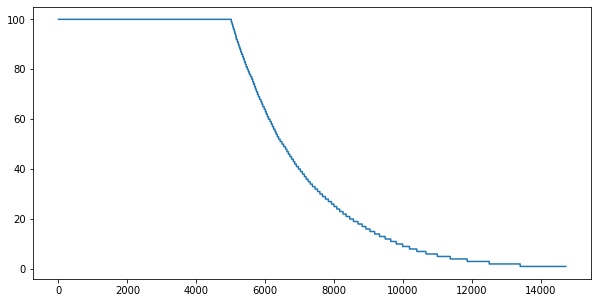

In [10]:
plt.figure(figsize=(10, 5), facecolor='w')
plt.plot(data1.groupby('movie_id').count().sort_values('review', ascending=False)['review'].values)
plt.show()

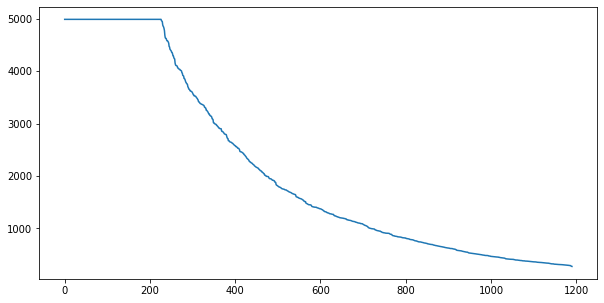

In [11]:
plt.figure(figsize=(10, 5), facecolor='w')
plt.plot(data2.groupby('movie_id').count().sort_values('review', ascending=False)['review'].values)
plt.show()

In [12]:
data2.loc[4, 'review']

'많이 울었습니다 화도 나고 속상하고 북한의 현실을 나라 꼭대기에 앉아있는 그 분과 그분의 추종자들도 꼭 보시길 바라는 그런 영화에요'

- 한글 이외의 문자 제거 전처리

In [13]:
mr = pd.concat((data1['review'], data2['review'])).values

In [14]:
import numpy as np

Arr = np.ones((3,4))
def foo(x):
    return x * x + 1

foo = np.vectorize(foo)  # 함수를 적용.  array에 적용가능하도록 변경. 

result = foo(Arr)  # Arr는 array의 이름임

In [15]:
Arr.shape

(3, 4)

In [16]:
tt = mr[:2000].copy()

In [17]:
def preprocess(x):
    return re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x)
preprocess = np.vectorize(preprocess)

In [18]:
preprocess

In [20]:
for i in [5, 50, 500, 2000, 5000, 10000]:
    tt = tt = mr[:i].copy()
    %timeit preprocess(tt)
    %timeit np.array(list(map(lambda x : re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x), tt)))
    print()

51.9 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
36 µs ± 874 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

284 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
250 µs ± 7.34 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

2.38 ms ± 98.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.15 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

9.98 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.5 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

25.3 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.9 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

50.7 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.7 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



In [21]:
%time mr2 = preprocess(mr)

Wall time: 14.8 s


In [26]:
mr2[:len(data1)]

array(['전체 관람가는 아닌 것 같아요', '디렉터스 컷으로 봐서 거의  시간 짜리인데 참 흡인력 있다',
       '태어나 처음으로 가슴 아리는 영화였다    년 이상 지났지만   생각하면 또 가슴이 아리는   황순원의 소나기에서 또 한번 느꼈던 그 느낌 ',
       ..., '단언컨 대 올 가을 최고의 영화   장담한다   ',
       '기대 없이 봤다가 너무 너무 반하게 된 영화  가을 감성에 딱 ',
       '나도 모르게 눈물이 주륵주륵  가을 감성 영화  강추         너무 좋아요     '], dtype='<U528')

In [29]:
mr2[len(data1):]

array(['감동입니다 말이 필요 없습니다 꼭 보세요 그리고 상영관을 늘려 주심 감사하겠습니다', '쩌네요 장관이구요 걸경입니다',
       '우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다',
       ..., '좋은 영화입니다 잘 봤습니다', '역대 사형수들에 관한 영화 중 가장 재미있었다', '비처럼 젖어드는 감동'],
      dtype='<U528')

In [31]:
data1.shape, data2.shape, mr2[:len(data1)].shape, mr2[len(data1):].shape

((712383, 3), (2532415, 3), (712383,), (2532415,))

In [32]:
data1['review2'] = mr2[:len(data1)]
data2['review2'] = mr2[len(data1):]

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
from chatspace import ChatSpace

spacer = ChatSpace()

Loading JIT Compiled ChatSpace Model


In [42]:
spacer.space('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ')

'너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'

In [45]:
spacer.model

ScriptModule(
  (embed): ScriptModule(
    (embedding): ScriptModule()
  )
  (conv): ScriptModule(
    (conv1): ScriptModule()
    (conv2): ScriptModule()
    (conv3): ScriptModule()
    (padding_1): ScriptModule()
    (padding_2): ScriptModule()
    (padding_3): ScriptModule()
  )
  (lstm): ScriptModule(
    (lstm): ScriptModule()
  )
  (projection): ScriptModule(
    (seq_fnn): ScriptModule(
      (layer): ScriptModule()
      (activation): ScriptModule()
    )
    (softmax): ScriptModule()
  )
  (fnn): ScriptModule(
    (time_distributed_1): ScriptModule(
      (layer): ScriptModule()
      (activation): ScriptModule()
    )
    (time_distributed_2): ScriptModule(
      (layer): ScriptModule()
      (activation): ScriptModule()
    )
  )
  (batch_normalization): ScriptModule()
  (layer_normalization): ScriptModule()
)

- 맞춤법 전처리

In [47]:
# -*- coding: utf-8 -*-
from collections import namedtuple
import time
from collections import OrderedDict
import sys
import xml.etree.ElementTree as ET
import requests

base_url = 'https://m.search.naver.com/p/csearch/ocontent/spellchecker.nhn'

_agent = requests.Session()
PY3 = sys.version_info[0] == 3

class CheckResult:
    PASSED = 0
    WRONG_SPELLING = 1
    WRONG_SPACING = 2
    AMBIGUOUS = 3

def _remove_tags(text):
    text = u'<content>{}</content>'.format(text).replace('<br>','')
    if not PY3:
        text = text.encode('utf-8')
    result = ''.join(ET.fromstring(text).itertext())
    return result

# 조사와 어미도 단어로 처리함. 마땅한 영단어가 생각이 안 나서..
_checked = namedtuple('Checked',
    ['result', 'original', 'checked', 'errors', 'words', 'time'])

class Checked(_checked):
    def __new__(cls, result=False, original='', checked='', 
                errors=0, words=[], time=0.0):
        return super(Checked, cls).__new__(
            cls, result, original, checked, errors, words, time)

    def as_dict(self):
        d = {
            'result': self.result,
            'original': self.original,
            'checked': self.checked,
            'errors': self.errors,
            'words': self.words,
            'time': self.time,
        }
        return d
    
def spallcheck(text):
    if isinstance(text, list):
        result = []
        for item in text:
            checked = spallcheck(item)
            result.append(checked)
        return result
    
    if len(text) > 500:
        return Checked(result=False)
    
    payload = {
        '_callback':'window.__jindo2_callback._spellingCheck_0',
        'q': text
    }
    headers = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
        'referer': 'https://search.naver.com/'
    }
    
    start_time = time.time()
    r = _agent.get(base_url, params=payload, headers=headers)
    passed_time = time.time() - start_time
    
    r = r.text[42:-2]
    
    data = json.loads(r)
    html = data['message']['result']['html']
    result = {
        'result': True,
        'original': text,
        'checked': _remove_tags(html),
        'errors': data['message']['result']['errata_count'],
        'time': passed_time,
        'words': OrderedDict(),
    }
    
    # 띄어쓰기로 구분하기 위해 태그는 일단 보기 쉽게 바꿔둠.
    # ElementTree의 iter()를 써서 더 좋게 할 수 있는 방법이 있지만
    # 이 짧은 코드에 굳이 그렇게 할 필요성이 없으므로 일단 문자열을 치환하는 방법으로 작성.
    html = html.replace('<span class=\'re_green\'>', '<green>') \
               .replace('<span class=\'re_red\'>', '<red>') \
               .replace('<span class=\'re_purple\'>', '<purple>') \
               .replace('</span>', '<end>')
    items = html.split(' ')
    words = []
    tmp = ''
    for word in items:
        if tmp == '' and word[:1] == '<':
            pos = word.find('>') + 1
            tmp = word[:pos]
        elif tmp != '':
            word = u'{}{}'.format(tmp, word)

        if word[-5:] == '<end>':
            word = word.replace('<end>', '')
            tmp = ''

        words.append(word)
        
    for word in words:
        check_result = CheckResult.PASSED
        if word[:5] == '<red>':
            check_result = CheckResult.WRONG_SPELLING
            word = word.replace('<red>', '')
        elif word[:7] == '<green>':
            check_result = CheckResult.WRONG_SPACING
            word = word.replace('<green>', '')
        elif word[:8] == '<purple>':
            check_result = CheckResult.AMBIGUOUS
            word = word.replace('<purple>', '')

        result['words'][word] = check_result

    result = Checked(**result)
    
    return result

In [52]:
ck = spallcheck(data1['review2'][0])

In [53]:
ck.errors

0

In [57]:
text = '너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'
ck = spallcheck(text)
print(ck.original)
print(ck.checked)

너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ
너 무 보고 싶은데 상영관이 없어요 ㅠ ㅜ


In [60]:
from konlpy.tag import Okt, Kkma
from eunjeon import Mecab

okt = Okt()
kkma = Kkma()
mecab = Mecab()

In [65]:
print(okt.morphs('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ', norm=True, stem=True))
print(okt.morphs('너 무 보고 싶은데 상영관이 없어요 ㅠ ㅜ', norm=True, stem=True))
print()
print(kkma.morphs('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'))
print(kkma.morphs('너 무 보고 싶은데 상영관이 없어요 ㅠ ㅜ'))
print()
print(mecab.morphs('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'))
print(mecab.morphs('너 무 보고 싶은데 상영관이 없어요 ㅠ ㅜ'))

['너', '무', '보고', '싶다', '상영', '관', '이', '없다', 'ㅠ', 'ㅜ']
['너', '무', '보고', '싶다', '상영', '관', '이', '없다', 'ㅠ', 'ㅜ']

['느', '어', '무', '보', '고', '싶', '은', '대', '상영관', '이', '없', '어요', 'ㅠ', 'ㅜ']
['느', '어', '무', '보', '고', '싶', '은', '데', '상영관', '이', '없', '어요', 'ㅠ', 'ㅜ']

['너', '무', '보', '고', '싶', '은대', '상영관', '이', '없', '어요', 'ㅠ', 'ㅜ']
['너', '무', '보', '고', '싶', '은데', '상영관', '이', '없', '어요', 'ㅠ', 'ㅜ']


In [88]:
stopwords = list('의가이은을로들는좀잘걍과도를자에와한것') + ['으로', '하다']
[morph for morph in okt.morphs(
    spacer.space(
        ''.join(
            mecab.morphs(
                spallcheck(
                    re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ',
                           '너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'
                          )
                ).checked
            )
        )
    ), stem=True, norm=True)
 if morph not in stopwords]

['너무', '보다', '상영', '관', '없다', 'ㅠ', 'ㅜ']

In [106]:
''.join(mecab.morphs('너 무 보고 싶은데 상관'))
%timeit mecab.morphs('너 무 보고 싶은데 상관')

12.4 µs ± 353 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [113]:
%timeit list('너 무 보고 싶은데 상관')
%timeit ''.join([i for i in '너 무 보고 싶은데 상관' if i != ' '])
%timeit '너 무 보고 싶은데 상관'.replace(' ', '')

568 ns ± 28.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.25 µs ± 87.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
120 ns ± 3.13 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [116]:
## 우선 function 2개를 입력받아서 composite function을 만들어주는 함수를 정의하고 
def compose2(func1, func2):## func1 first applied
    return lambda x: func2(func1(x))
## 순서대로 적용될 함수리스트 
pipes = [lambda x: x+1, lambda x: x*2, lambda x: x*10]
## reduce를 통해 함수2을 섞어서 새로운 함수를 만드는 일을 반복함
comp_func = functools.reduce(compose2, pipes)
for i, x in enumerate(range(5, 10)):
    print(f"{i}: {comp_func(x)}")

0: 120
1: 140
2: 160
3: 180
4: 200


In [222]:
reviews.values

array(['감동입니다 말이 필요 없습니다 꼭 보세요 그리고 상영관을 늘려 주심 감사하겠습니다', '쩌네요 장관이구요 걸경입니다',
       '우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다',
       ..., '좋은 영화입니다 잘 봤습니다', '역대 사형수들에 관한 영화 중 가장 재미있었다', '비처럼 젖어드는 감동'],
      dtype=object)

In [429]:
# https://frhyme.github.io/python-lib/pipeline_in_python/

stopwords = list('의가이은을로들는좀잘걍과도를자에그와한것다') + ['으로', '하다', '에서', '이다']

def composeFuncs(func1, func2):
    return lambda x : func2(func1(x))

pipes = [lambda x : re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x),
         lambda x : spallcheck(x).checked,
         lambda x : x.replace(' ', ''),
         lambda x : spacer.space(x),
         lambda x : okt.morphs(x, stem=True, norm=True),
#          lambda x : mecab.morphs(''.join(x)),
         lambda x : [s for s in x if s not in stopwords]]

preprocessText = functools.reduce(composeFuncs, pipes)

In [430]:
preprocessText('너무재밓었다그래서추천한다')

['너무', '재밓었다', '그래서', '추천']

In [431]:
preprocessText('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ')

['너무', '보다', '상영', '관', '없다', 'ㅠ', 'ㅜ']

In [432]:
preprocessText('우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다')

['우리',
 '민족',
 '북한',
 '말',
 '지상',
 '낙원',
 '아니다',
 '생지옥',
 '생',
 '감옥',
 '지금',
 '시간',
 '에도',
 '곳',
 '고통',
 '받다',
 '있다',
 '끔찍하다']

In [433]:
preprocessText('태어나 처음으로 가슴 아리는 영화였다. 20년 이상 지났지만.. 생각하면 또 가슴이 아리는.. 황순원의 소나기에서 또 한번 느꼈던 그 느낌!')

['태어나다',
 '처음',
 '가슴',
 '아리다',
 '영화',
 '년',
 '이상',
 '지나다',
 '생각',
 '또',
 '가슴',
 '아리다',
 '황순원',
 '소나기',
 '또',
 '한번',
 '느끼다',
 '느낌']

In [436]:
mr5over[5:10]

array(['인생 최고의 영화. 말이 필요 없음. 감독판은 감동이 좀 덜함.',
       '아름다운 영화 지금까지 봤던 영화 중 끝까지 감동적이었던 영화',
       "여지껏 내 인생에서 젤 감동인 영화~! 영화음악의 거장 '엔 리오모 리꼬 네'의 OST까지 완벽하다...",
       '내가 죽을 때까지 이런 명작은 나오기 힘들 것 같다.. 너무 아름답고 감동적인 영화..',
       '내 인생 최고의 영화!! 아직까지 이 영화를 봤을 때의 감동을 잊을 수 없다.'], dtype=object)

In [ ]:
%time reviews = list(map(lambda s : preprocessText(s), reviews))

In [440]:
list(map(lambda  x : preprocessText(x), mr5over[5:10]))

[['인생', '최고', '영화', '말', '필요없다', '감독판', '감동', '덜하다'],
 ['아름답다', '영화', '지금', '까지', '보다', '영화', '중', '끝', '까지', '감동', '적', '영화'],
 ['여태껏',
  '내',
  '인생',
  '젤',
  '감동',
  '인',
  '영화',
  '영화',
  '음악',
  '거장',
  '엔',
  '리오',
  '모르꼬',
  '네',
  '위',
  '까지',
  '완벽하다'],
 ['내',
  '죽',
  '때',
  '까지',
  '이렇다',
  '명작',
  '나오다',
  '힘들다',
  '같다',
  '너무',
  '아름답다',
  '감동',
  '적',
  '인',
  '영화'],
 ['내', '인생', '최고', '영화', '아직', '까지', '영화', '보다', '때', '감동', '잊다', '수', '없다']]

In [401]:
text = '너무재밓었다그래서추천한다'
okt.morphs(spacer.space(spallcheck(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', text)).checked.replace(' ', '')), stem=True, norm=True)

['너무', '재밓었다', '그래서', '추천', '하다']

In [457]:
reviews5over = pd.DataFrame(mr5over, columns=['reviews'])
reviews5over.to_csv('reviews5over.csv', index=False)

# 돌현아 호려라

In [450]:
# https://frhyme.github.io/python-lib/pipeline_in_python/

import re
from chatspace import ChatSpace # Requirements;
                                # https://lsjsj92.tistory.com/494
                                # conda install pytorch torchvision cudatoolkit=9.0 -c python
                                # pip install chatspace
from konlpy.tag import Okt
import functools
spacer = ChatSpace()
okt = Okt()

stopwords = list('의가이은을로들는좀잘걍과도를자에그와한것다') + ['으로', '하다', '에서', '이다']

def composeFuncs(func1, func2):
    return lambda x : func2(func1(x))

pipes = [lambda x : re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x),
         lambda x : spallcheck(x).checked,
         lambda x : x.replace(' ', ''),
         lambda x : spacer.space(x),
         lambda x : okt.morphs(x, stem=True, norm=True),
#          lambda x : mecab.morphs(''.join(x)),
         lambda x : [s for s in x if s not in stopwords]]

preprocessText = functools.reduce(composeFuncs, pipes)

Loading JIT Compiled ChatSpace Model


In [458]:
reviews5over = pd.read_csv('reviews5over.csv')

In [459]:
reviews5over.head()

,reviews
0,전체 관람가는 아닌 것 같아요
1,디렉터스 컷으로 봐서 거의 3시간 짜리인데 참 흡인력 있다
2,태어나 처음으로 가슴 아리는 영화였다. 20년 이상 지났지만.. 생각하면 또 가슴이...
3,어린시절 고딩 때 봤던 때랑 또 결혼하고 나서 봤을 때의 느낌은 확실히 다르네요. ...
4,토토에게 넓은 세상을 보여주고 픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 ...


In [461]:
reviews5over.size

2468027

In [492]:
import pickle
import time
res = []
start, semi_start = time.time(), time.time()
for ix, text in enumerate(reviews5over['reviews'].values):
    # 1,000개마다 결과 출력
    if ix % 1000 == 0:
        print(ix, '\t\tcollapse {:.2f} mins\t\tcumulative time is {:.2f} mins'.format(
            (time.time() - semi_start) / 60, (time.time() - start) / 60))
        semi_start = time.time()
    res.append(preprocessText(text))
    # 100,000개마다 결과 저장
    if ix % 100000 == 0:
        with open('preprocessReview_{}'.format(ix), 'wb') as f:
            pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)
        res = []

0 		collapse 0.00 mins		cumulative time is 0.00 mins
1000 		collapse 1.11 mins		cumulative time is 1.11 mins
2000 		collapse 1.06 mins		cumulative time is 2.17 mins


---

In [406]:
text = '너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'
print(okt.morphs(spacer.space(text), stem=True, norm=True))
print(preprocessText(text))
print(preprocessText2(text))
print(preprocessText3(text))
print(preprocessText4(text))
print(preprocessText5(text))
print(preprocessText6(text))
print(preprocessText7(text))
print(preprocessText10(text))

['너', '무', '보고', '싶다', '상영', '관', '이', '없다', 'ㅠ', 'ㅜ']
['너무', '보다', '상영관', '없', 'ㅠㅜ']
['너무', '보다', '상영관', '없', 'ㅠㅜ']
['너무', '보다', '대상', '영관', '없', 'ㅠㅜ']
['너무', '보', '고', '싶', '상영관', '없', 'ㅠㅜ']
['너무', '보다', '상영관', '없', 'ㅠㅜ']
['너무', '보', '고', '싶', '은데', '상영관', '없', '어요', 'ㅠ', 'ㅜ']
['너무', '보다', '상영관', '이', '없', '다', 'ㅠㅜ']
['너무', '보다', '상영', '관', '없다', 'ㅠ', 'ㅜ']


In [410]:
text = '우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다'
print(okt.morphs(spacer.space(text), stem=True, norm=True))
print(preprocessText(text))
print(preprocessText2(text))
print(preprocessText3(text))
print(preprocessText4(text))
print(preprocessText5(text))
print(preprocessText6(text))
print(preprocessText7(text))
print(preprocessText10(text))

['우리', '민족', '이', '북한', '이', '말', '하다', '지상', '낙원', '이', '아니다', '생지옥', '생', '감옥', '에', '지금', '이', '시간', '에도', '그', '곳', '에서', '고통', '받다', '있다', '것', '이', '끔찍하다']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그곳', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그곳', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그곳', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그곳', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그곳', '고통', '받', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '라', '생지옥', '생', '감옥', '지금', '시간', '그곳', '고통', '받', '고', '있', '다는', '끔찍', '합니다']
['우리', '민족', '이', '북한', '이', '말', '하', '다', '지상', '낙원', '이', '아니', '다', '생지옥', '생', '감옥', '에', '지금', '이', '시간', '에', '도', '그곳', '에서', '고통', '받', '다', '있', '다', '것', 

In [409]:
text = '너무재밓었다그래서추천한다'
print(okt.morphs(spacer.space(text), stem=True, norm=True))
print(preprocessText(text))
print(preprocessText2(text))
print(preprocessText3(text))
print(preprocessText4(text))
print(preprocessText5(text))
print(preprocessText6(text))
print(preprocessText7(text))
print(preprocessText10(text))

['너무', '재밓었다', '그래서', '추천', '하다']
['너무', '재', '밓었다그래서추천하다']
['너무', '재', '밓었다그래서추천하다']
['너무', '재', '밓었다그래서추천하다']
['너무', '재', '밓었다그래서추천하다']
['너무', '재', '밓었다그래서추천한다']
['너무', '재', '밓었다', '그래서', '추천', '한다']
['너무', '재', '밓었다그래서추천하다']
['너무', '재밓었다', '그래서', '추천']


In [288]:
%time res = reviews.sample(100, random_state=42).map(preprocessText)

Wall time: 5.42 s


In [327]:
%time ind = pd.Series(mr).map(lambda x : len(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x).split(' ')) >= 5)

Wall time: 13.9 s


In [328]:
ind.sum() / len(ind)

0.7606103677332148

In [333]:
mr5over = mr[np.where(ind)[0]]
mr5less = mr[np.where(~ind)[0]]

In [334]:
mr5over

array(['전체 관람가는 아닌 것 같아요', '디렉터스 컷으로 봐서 거의 3시간 짜리인데 참 흡인력 있다',
       '태어나 처음으로 가슴 아리는 영화였다. 20년 이상 지났지만.. 생각하면 또 가슴이 아리는.. 황순원의 소나기에서 또 한번 느꼈던 그 느낌!',
       ..., '저도 방금 에서 봤거든요 감동 ㅠ ㅠ', '오랜만에 좋은 영화 본 것 같은 느낌',
       '역대 사형수들에 관한 영화 중 가장 재미있었다'], dtype=object)

In [336]:
mr5less

array(['전율과 여운이 남는 영화', '최고입니다 마스터피스', '방심하면 저처럼 웁니다', ...,
       '이 영화 보구 울었어요', '좋은 영화입니다 잘 봤습니다', '비처럼 젖어드는 감동'], dtype=object)

- test

In [340]:
ind2 = np.arange(mr5over.shape[0])
np.random.shuffle(ind2)

In [343]:
preprocessTextVectorize = np.vectorize(preprocessText)

In [274]:
mecab.morphs(' '.join(okt.morphs(spacer.space('너무재밌었다그래서추천한다'), stem=True, norm=True)[:-1]))

['너무', '재밌', '다', '그래서', '추천']

In [276]:
spallcheck('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ')

Checked(result=True, original='너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ', checked='너 무 보고 싶은데 상영관이 없어요 ㅠ ㅜ', errors=1, words=OrderedDict([('너', 0), ('무', 0), ('보고', 0), ('<span', 0), ("class='red_text'>싶은데", 0), ('상영관이', 0), ('없어요', 0), ('ㅠ', 0), ('ㅜ', 0)]), time=0.02098989486694336)

In [278]:
spallcheck('쩌네요 장관이구요 걸경입니다')

Checked(result=True, original='쩌네요 장관이구요 걸경입니다', checked='쩌네요 장관이고요 불경입니다', errors=3, words=OrderedDict([('<span', 0), ("class='violet_text'>쩌네요", 0), ("class='red_text'>장관이고요", 0), ("class='blue_text'>불경입니다", 0)]), time=0.13364148139953613)

In [275]:
print(okt.morphs('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ', norm=True, stem=True))
print(preprocessText('너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ'))
print(preprocessText('너 무 보고 싶은대 상영관이 없다 ㅠ ㅜ'))
print(preprocessText('너 무 보고 싶은대 상영관이 없네요 ㅠ ㅜ'))

['너', '무', '보고', '싶다', '상영', '관', '이', '없다', 'ㅠ', 'ㅜ']
['너무', '보다', '상영', '관', '없다', 'ㅠ', 'ㅜ']
['너무', '보고', '싶다', '상영', '관', '없다', 'ㅠ', 'ㅜ']
['너무', '보다', '상영', '관', '없다', 'ㅠ', 'ㅜ']


In [202]:
soylemmma_git_repository = "C:/research_persona/korean_lemmatizer"
sys.path.append(soylemmma_git_repository)

from soylemma import Lemmatizer
lemmatizer = Lemmatizer()
lemmatizer.analyze('차가우니까')

[(('차갑', 'Adjective'), ('우니까', 'Eomi'))]

In [220]:
lemmatizer.analyze('재밓다')

[]

In [189]:
text = '너무재밓었다그래서추천한다'
print(okt.morphs(text, norm=True, stem=True))
print(preprocessText(text))
print(preprocessText(text))
print(preprocessText(text))
print(okt.morphs(spacer.space(text), stem=True, norm=True))

['너', '무재', '밓었', '다그', '래서', '추천', '한', '다']
['너무', '재', '밓었다', '그래서', '추천', '하']
['너무', '재', '밓었다', '그래서', '추천', '하']
['너무', '재', '밓었다', '그래서', '추천', '하']
['너무', '재밓었다', '그래서', '추천', '하다']


In [223]:
text = '우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다'
print(okt.morphs(text, norm=True, stem=True))
print(preprocessText(text))
print(preprocessText(text))
print(preprocessText(text))
print(okt.morphs(spacer.space(text), stem=True, norm=True))

['우리', '민족', '이', '북한', '이', '말', '하다', '지상', '낙원', '이', '아니다', '생지옥', '생', '감옥', '에', '지금', '이', '시간', '에도', '그', '곳', '에서', '고통', '받다', '있다', '것', '이', '끔찍하다']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그', '곳', '에서', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그', '곳', '에서', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '북한', '말', '하', '지상', '낙원', '아니', '생지옥', '생', '감옥', '지금', '시간', '그', '곳', '에서', '고통', '받', '있', '끔찍', '하']
['우리', '민족', '이', '북한', '이', '말', '하다', '지상', '낙원', '이', '아니다', '생지옥', '생', '감옥', '에', '지금', '이', '시간', '에도', '그', '곳', '에서', '고통', '받다', '있다', '것', '이', '끔찍하다']


In [227]:
text = '우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다'
print(okt.morphs(text, norm=True, stem=True))
print(preprocessText(text))
print(preprocessText(text))
print(preprocessText(text))
print(okt.morphs(spacer.space(text), stem=True, norm=True))

['우리', '민족', '이', '북한', '이', '말', '하다', '지상', '낙원', '이', '아니다', '생지옥', '생', '감옥', '에', '지금', '이', '시간', '에도', '그', '곳', '에서', '고통', '받다', '있다', '것', '이', '끔찍하다']
['우리', '민족', '북한', '말', '지상', '낙원', '아니다', '생지옥', '생', '감옥', '지금', '시간', '에도', '그', '곳', '고통', '받다', '있다', '끔찍하다']
['우리', '민족', '북한', '말', '지상', '낙원', '아니다', '생지옥', '생', '감옥', '지금', '시간', '에도', '그', '곳', '고통', '받다', '있다', '끔찍하다']
['우리', '민족', '북한', '말', '지상', '낙원', '아니다', '생지옥', '생', '감옥', '지금', '시간', '에도', '그', '곳', '고통', '받다', '있다', '끔찍하다']
['우리', '민족', '이', '북한', '이', '말', '하다', '지상', '낙원', '이', '아니다', '생지옥', '생', '감옥', '에', '지금', '이', '시간', '에도', '그', '곳', '에서', '고통', '받다', '있다', '것', '이', '끔찍하다']


In [267]:
spallcheck('쩌네요 장관이구요 걸경입니다')

Checked(result=True, original='쩌네요 장관이구요 걸경입니다', checked='쩌네요 장관이고요 불경입니다', errors=3, words=OrderedDict([('<span', 0), ("class='violet_text'>쩌네요", 0), ("class='red_text'>장관이고요", 0), ("class='blue_text'>불경입니다", 0)]), time=0.12869668006896973)

In [265]:
text = '쩌네요 장관이구요 걸경입니다'
print(okt.morphs(text, norm=True, stem=True))
print(preprocessText(text))
print(preprocessText(text))
print(preprocessText(text))
print(okt.morphs(spacer.space(text), stem=True, norm=True))

['쩌네', '요', '장관', '이구', '요', '걸경', '이다']
['쩌네', '요', '장관', '고요', '불경', '이다']
['쩌네', '요', '장관', '고요', '불경', '이다']
['쩌네', '요', '장관', '고요', '불경', '이다']
['쩌네', '요', '장관', '이구', '요', '걸경', '이다']


### 띄어쓰기 전처리 차이별 성능 비교 정리하기
- 경우의 수
    - spaceing 전처리
    - 불용어 처리
    - 한글 이외의 텍스트 제거
- 최종 결과단에서는 stem 추출을 위해 Okt tokenizer 활용

In [ ]:
ck = spallcheck(df2['review'][0])
ck.errors
res = []
for ix, review in df2['review'].items():
    if ix % 100 == 0:
        print(ix)
    ck = spallcheck(review)
    res.append(ck.checked)

In [46]:
data2['review2'].tolist()

['감동입니다 말이 필요 없습니다 꼭 보세요 그리고 상영관을 늘려 주심 감사하겠습니다',
 '쩌네요 장관이구요 걸경입니다',
 '우리 민족이 북한이 말하는 지상 낙원이 아니라 생지옥 생감옥에 지금 이 시간에도 그곳에서 고통 받고 있다는 것이 끔찍합니다',
 '북한의 현실을 보여주는 영화입니다 정말 이런 영화가 많이 배급되어야 합니다',
 '많이 울었습니다 화도 나고 속상하고 북한의 현실을 나라 꼭대기에 앉아있는 그 분과 그분의 추종자들도 꼭 보시길 바라는 그런 영화에요',
 '모든 국민이 다 봐야 되는 영화',
 '북한의 실상에 대해 더 절실히 알게 되는 영화였습니다 귀한 영화 만들어 주셔서 감사합니다',
 '북한의 실상을 보여주는 가슴 아픈 영화였습니다 하루 빨리 북한에도 진정한 자유가 주어지기를 바랍니다',
 '이건 꼭 봐야 할 영화입니다',
 '현실은 우리를 행동하게 만드다 영화를 보는 내내 정말 현실이지 않기를 바랬던 유일한 영화',
 '최고의 영화 다들 꼭 봐야 할 영화입니다',
 '진짜 꼭 봐야 될 영화입니다',
 '북한 신봉하는 놈들아 제발 정신 좀 차리길 자본주의에서 누릴 거 다 누려놓고 북한 빠는 거 보면 졸 웃김',
 '자유 민주주의를 위하여 북한의 인권을 위하여',
 '적어도 만명 돌파는 가야합니다 상영관 멀어서 못가시는 분들은 좌파들처럼 영혼 보냅시다',
 '재인이가 이 영화를 싫어합니다',
 '실화를 바탕으로 제작한 영화 대한민국 국민 모두가 꼭 봐야 할 영화입니다 물론 미성년은 부모 동의하에',
 '독립영화 화이팅',
 '이렇게 훌륭한 영화가 국내에서 외면 받는 현실이 참 슬프네요',
 '관람객 인권의 대지로 건너가는 징검 다리의 돌 하나같은 영화 북한 인권에 대한 관심이 끊어져서는 안된다 영화 자체로서는 아쉬움이 남았다',
 '관람객 참 인생에 남을 명작 이었습니다',
 '너 무 보고 싶은대 상영관이 없어요 ㅠ ㅜ',
 '가족을 향한 따뜻함이 오랫동안 여운이 남는 영화입니다',
 '대한민국 국민은 다 봐야 할 영화 다라는 생각이 드네

In [ ]:
mr2[data2.index].shape

# Find 최적의 Topics의 수, K